## The Poisson as a limiting case of the Binomial

Consider a Binomial process with $N$ trials and success probability $p$. We wish to consider the situation where $N \to \infty$ and $p \to 0$ but $N p = \lambda$, a constant. In this case, the probability of $k$ successes in $N$ trials is:
\begin{align*}
{N \choose k} p^k (1 - p)^{N - k} & = \frac{N!}{k! (N - k)!} p^k (1 - p)^{N - k} \\
    & = \frac{1}{k!} \cdot \frac{(N - k + 1) (N - k + 2) \cdots N}{N^k} 
        \cdot (Np)^k 
        \cdot \left ( 1 - \frac{\lambda}{N} \right )^{N - k} \\
    & = \frac{\lambda^k}{k!} \left ( 1 - \frac{k - 1}{N} \right ) 
        \left ( 1 - \frac{k - 2}{N} \right ) \frac{N}{N} 
        \cdot \frac{1}{(1 - \lambda / N)^k} \cdot \left ( 1 - \frac{\lambda}{N}\right )^N 
\end{align*}
As $N \to \infty$ and $p \to 0$, the above approaches $\lambda^k e^{-\lambda} / k!$, which is the pmf of the Poisson distribution.

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

from scipy.stats import binom, poisson, norm 

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
y = binom.rvs(n=1000, p=1/1000, size=int(1e5))
np.mean(y), np.var(y)

(0.99887, 0.9957087231000002)

## Poisson Regression

\begin{align*}
    y_i              & \sim \text{Poisson}(\lambda_i) \\
    \log (\lambda_i) & = \alpha + \beta (x_i - \bar{x})
\end{align*}

### Oceanic Tool Complexity

In [3]:
KLINE_DATASET = '../../data/kline.csv'

In [4]:
df = pd.read_csv(KLINE_DATASET)
df

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


### Code 11.37

In [5]:
df.loc[:, 'log_p'] = np.log(df['population'].values)
df.loc[:, 'contact_id'] = np.where(df['contact'] == 'high', 1, 0)

In [6]:
df

,culture,population,contact,total_tools,mean_TU,log_p,contact_id
0,Malekula,1100,low,13,3.2,7.003065,0
1,Tikopia,1500,low,22,4.7,7.313220,0
2,Santa Cruz,3600,low,24,4.0,8.188689,0
3,Yap,4791,high,43,5.0,8.474494,1
4,Lau Fiji,7400,high,33,5.0,8.909235,1
5,Trobriand,8000,high,19,4.0,8.987197,1
6,Chuuk,9200,high,40,3.8,9.126959,1
7,Manus,13000,low,28,6.6,9.472705,0
8,Tonga,17500,high,55,5.4,9.769956,1
9,Hawaii,275000,low,71,6.6,12.524526,0


# The Model

The model postulates that the number of tools used (`total_tools`) in a given `culture` varies as follows:

1. the `total_tools` increases with the log of the `population` 
2. the `total_tools` increases with the `contact` rate
3. the impact of `population` on `total_tools` is moderated by the `contact` rate

\begin{align*}
    T_i                & \sim \text{Poisson}(\lambda_i) \\
    \log \lambda_i     & = \alpha_{\text{cid}[i]} + \beta_{\text{cid}[i]} \cdot \log P_i \\
    \alpha_0, \alpha_1 & \sim \text{ to be determined } \\
    \beta_0, \beta_1   & \sim \text{ to be determined }
\end{align*}

## Determining Priors

### Model with intercept only

\begin{align*}
    T_i                & \sim \text{Poisson}(\lambda_i) \\
    \log \lambda_i     & = \alpha \\
    \alpha             & \sim \text{Normal}(0, 10) \\
\end{align*}

If $\alpha$ has the normal distribution, then $\lambda$ has the log-normal distribution. The pdf of the log-normal distribution is:

$$
    \frac{1}{x \sigma \sqrt{2 \pi}} \cdot \exp \left \{ - \frac{(\log x - \mu)^2}{2 \sigma^2} \right \} .
$$
The mean of the distribution is $\exp(\mu + \sigma^2 / 2)$.

In [7]:
def my_lognorm(x, mu, sigma):
    def _inner(y):
        if y < 1e-4:
            return 0.0
        else:
            return 1 / (y * sigma * np.sqrt(2 * np.pi)) * np.exp(-1 * (np.log(y) - mu)**2 / (2 * sigma**2))
        
    inner_func = np.vectorize(_inner)
    return inner_func(x)

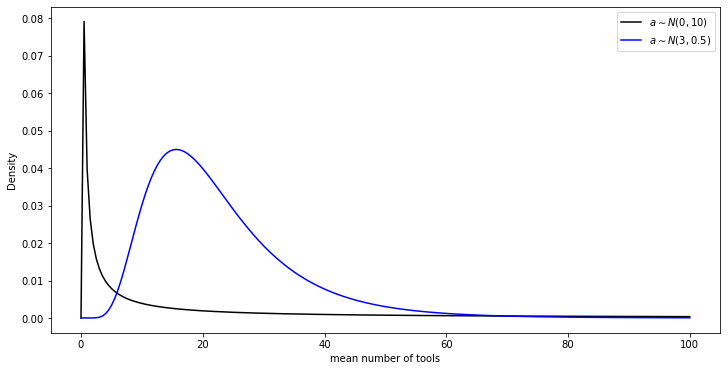

In [8]:
import seaborn as sns


x_vals = np.linspace(0, 100, 200)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x_vals, my_lognorm(x_vals, mu=0, sigma=10), 'k', label=r'$a \sim N(0, 10)$')
ax.plot(x_vals, my_lognorm(x_vals, mu=3, sigma=0.5), 'b', label=r'$a \sim N(3, 0.5)$')

ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")

plt.legend()
plt.show();

### Code 11.41

In [9]:
def plot_prior_predictive(N=100, a_mu=3, a_sd=0.5, b_mu=0, b_sd=10, log_pop_std=True):
    a = norm.rvs(loc=a_mu, scale=a_sd, size=N)
    b = norm.rvs(loc=b_mu, scale=b_sd, size=N)

    fig, ax = plt.subplots(1, 1,figsize=(8, 6))
    
    lo_x = -2
    hi_x = 2
    hi_y = 100
    
    xlabel = 'log population (std)'
    title = f'a ~ norm({a_mu}, {a_sd}), b ~ norm({b_mu}, {b_sd})'
    
    if not log_pop_std:
        lo_x = np.log(100)
        hi_x = np.log(20000)
        hi_y = 500
        xlabel = 'log population'
        
    ax.set_xlim(lo_x, hi_x)
    x_vals = np.linspace(lo_x, hi_x, N)
    ax.set_ylim(0, hi_y)

    
    for i in range(N):
        y_vals = np.exp(a[i] + b[i] * x_vals)
        ax.plot(x_vals, y_vals, 'k', alpha=0.4)

    ax.set_xlabel(xlabel)
    ax.set_ylabel('total tools')
    ax.set_title(title);

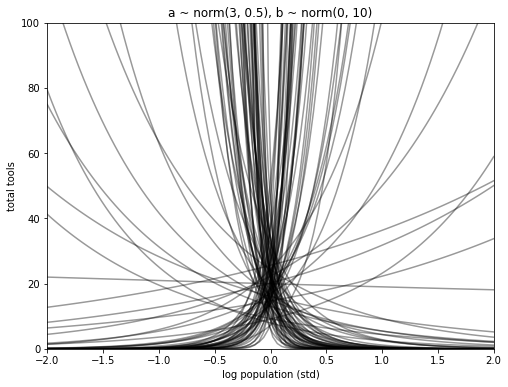

In [10]:
plot_prior_predictive()

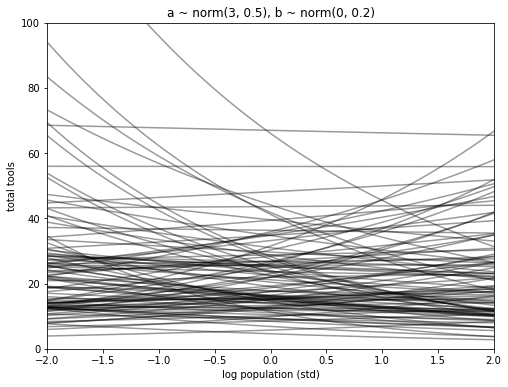

In [11]:
plot_prior_predictive(b_sd=0.2)

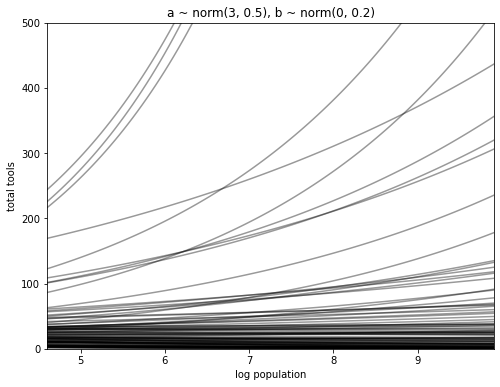

In [12]:
plot_prior_predictive(b_sd=0.2, log_pop_std=False)

In [13]:
def plot_prior_predictive_II(N=100, a_mu=3, a_sd=0.5, b_mu=0, b_sd=10):
    a = norm.rvs(loc=a_mu, scale=a_sd, size=N)
    b = norm.rvs(loc=b_mu, scale=b_sd, size=N)

    fig, ax = plt.subplots(1, 1,figsize=(8, 6))
    
    lo_x = 100
    hi_x = 200000
    hi_y = 500
    xlabel = 'population'
    title = f'a ~ norm({a_mu}, {a_sd}), b ~ norm({b_mu}, {b_sd})'
        
    ax.set_xlim(lo_x, hi_x)
   
    x_seq = np.linspace(np.log(lo_x), np.log(hi_x), N)
    ax.set_ylim(0, hi_y)

    for i in range(N):
        y_vals = np.exp(a[i] + b[i] * x_seq)
        ax.plot(np.exp(x_seq), y_vals, 'k', alpha=0.4)

    ax.set_xlabel(xlabel)
    ax.set_ylabel('total tools')
    ax.set_title(title);

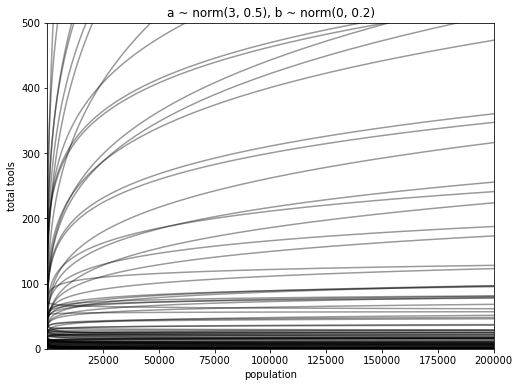

In [14]:
plot_prior_predictive_II(b_sd=0.2)

## Posterior Distributions

### Code 11.45

In [15]:
with pm.Model() as m_11_9:
    a = pm.Normal('a', mu=3.0, sigma=0.5)
    T = pm.Poisson('T', mu=pm.math.exp(a), observed=df['total_tools'])
    
    trace_11_9 = pm.sample(2000, tune=2000, return_inferencedata=False)

az.summary(trace_11_9, hdi_prob=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,3.54,0.05,3.46,3.63,0.0,0.0,3696.21,5371.05,1.0


In [16]:
def scale(np_arr):
    """Standardize a numpy array"""
    return (np_arr - np_arr.mean()) / np_arr.std()

In [17]:
log_pop_std = scale(df.log_p.values)

with pm.Model() as m_11_10:
    a = pm.Normal('a', mu=3, sigma=0.5, shape=df['contact'].nunique())
    b = pm.Normal('b', mu=0, sigma=0.5, shape=df['contact'].nunique())
    
    cid = pm.intX(pm.Data('cid', df.contact_id))
    log_pop = pm.Data('log_pop_std', log_pop_std)
    
    lam = pm.math.exp(a[cid] + b[cid] * log_pop)
    T = pm.Poisson('T', mu=lam, observed=df['total_tools'])
    
    trace_11_10 = pm.sample(2000, tune=2000, return_inferencedata=False)
    
az.summary(trace_11_10, var_names=['a', 'b'], hdi_prob=0.89, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],3.30,0.09,3.16,3.45,0.0,0.0,8209.25,6159.51,1.0
a[1],3.59,0.08,3.47,3.71,0.0,0.0,9159.31,6225.38,1.0
b[0],0.38,0.05,0.30,0.46,0.0,0.0,7811.76,5949.86,1.0
b[1],0.40,0.22,0.04,0.75,0.0,0.0,9513.47,6568.49,1.0


### Code 11.46

In [18]:
az.compare({'m_11_9': trace_11_9, 'm_11_10': trace_11_10}, ic='loo', method='BB-pseudo-BMA')

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robu

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_11_10,0,-43.878932,8.858069,0.00000,0.991832,15.679081,0.000000,True,log
m_11_9,1,-70.902692,8.383819,27.02376,0.008168,5.850271,16.443027,True,log


In [19]:
az.loo(trace_11_10, pointwise=True).pareto_k.values

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


array([0.33812289, 0.31924688, 0.26491664, 1.04989361, 0.29279041,
       0.54078237, 0.21375755, 0.45357483, 1.02208   , 1.12078077])

In [20]:
az.loo(trace_11_9, pointwise=True).pareto_k.values

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


array([0.38252491, 0.22917985, 0.1980443 , 0.29229435, 0.10666121,
       0.27836377, 0.24270354, 0.14240991, 0.53571403, 0.88937039])

### Code 11.47

In [21]:
k = az.loo(trace_11_10, pointwise=True).pareto_k.values

/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [22]:
df.loc[:, 'k_values'] = k

In [23]:
df

,culture,population,contact,total_tools,mean_TU,log_p,contact_id,k_values
0,Malekula,1100,low,13,3.2,7.003065,0,0.338123
1,Tikopia,1500,low,22,4.7,7.313220,0,0.319247
2,Santa Cruz,3600,low,24,4.0,8.188689,0,0.264917
3,Yap,4791,high,43,5.0,8.474494,1,1.049894
4,Lau Fiji,7400,high,33,5.0,8.909235,1,0.292790
5,Trobriand,8000,high,19,4.0,8.987197,1,0.540782
6,Chuuk,9200,high,40,3.8,9.126959,1,0.213758
7,Manus,13000,low,28,6.6,9.472705,0,0.453575
8,Tonga,17500,high,55,5.4,9.769956,1,1.022080
9,Hawaii,275000,low,71,6.6,12.524526,0,1.120781


In [24]:
num_samples = 100
log_pop_seq = np.linspace(-1.4, 3.0, num_samples)

with m_11_10:
    pm.set_data({'cid': np.array([0] * num_samples), 'log_pop_std': log_pop_seq})
    lam_0 = pm.sample_posterior_predictive(trace_11_10, var_names=['T'])['T']
    
    pm.set_data({'cid': np.array([1] * num_samples), 'log_pop_std': log_pop_seq})
    lam_1 = pm.sample_posterior_predictive(trace_11_10, var_names=['T'])['T']


In [25]:
type(lam_0)

numpy.ndarray

In [26]:
lam_0.shape

(8000, 100)

In [27]:
# take the column-wise means. This would give the posterior mean for each log_pop_seq value
lmu_0 = lam_0.mean(0)
lmu_1 = lam_1.mean(0)

In [28]:
lmu_0.shape, lmu_1.shape

((100,), (100,))

## Draw the Posterior Means Plot

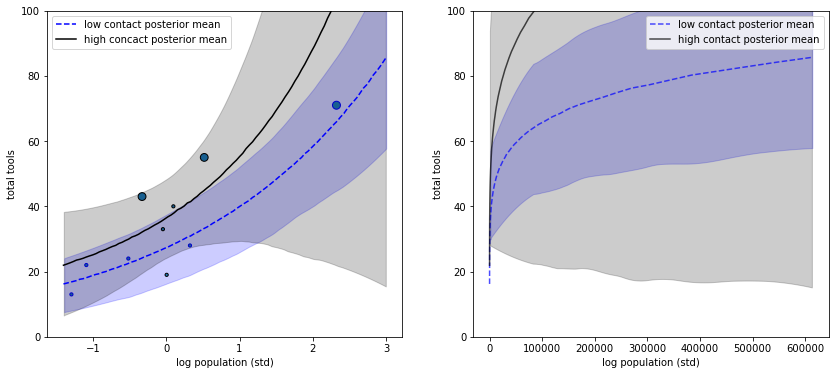

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6))

az.plot_hdi(log_pop_seq, lam_0, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(log_pop_seq, lmu_0, 'b--', label='low contact posterior mean')

# Plot the points
fill = ['blue' if contact == 'low' else 'black' for contact in df.contact]
size = [10 if k < 0.7 else 30 * (1 + k) for k in df.k_values]

ax0.scatter(scale(df.log_p), df.total_tools, edgecolor=fill, s=size)

az.plot_hdi(log_pop_seq, lam_1, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(log_pop_seq, lmu_1, 'k', label='high concact posterior mean')


log_pop_seq_II = np.linspace(-5.0, 3.0, num_samples)
pop_seq = np.exp(log_pop_seq_II * df.log_p.values.std() + df.log_p.values.mean())

az.plot_hdi(pop_seq, lam_0, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(pop_seq, lmu_0, "b--", alpha=0.7, label='low contact posterior mean')

az.plot_hdi(pop_seq, lam_1, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(pop_seq, lmu_1, "k", alpha=0.7, label='high contact posterior mean')


for ax in [ax0, ax1]:
    ax.set_xlabel('log population (std)')
    ax.set_ylabel('total tools')
    ax.set_ylim(0, 100)
    ax.legend();